In [1]:
from scipy.linalg import eig,eigh
from scipy.stats import pearsonr

import panel as pn, holoviews as hv, numpy as np
import param
pn.extension('katex','plotly')
hv.extension('bokeh')

from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main

import logging

# Suppress overly verbose logging
logging.disable(logging.CRITICAL)

%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [2]:
%%julia
using Pkg
gla_dir = "../GenLinAlgProblems"
Pkg.activate(gla_dir)
using GenLinAlgProblems, LinearAlgebra, LaTeXStrings, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix");

  Activating project at `C:\Users\jeff\NOTEBOOKS\elementary-linear-algebra\GenLinAlgProblems`


In [3]:
def stem(data, color='black', marker=True, label=None, hline=None):
    """Stem plot: data=(x, y, e). Draws vertical lines from y to e.
    Optionally adds a horizontal line at hline."""
    x, y, e = data
    vlines = [np.array([[x[i], y[i]], [x[i], e[i]]]) for i in range(len(x))]
    stems = hv.Path(vlines).opts(color=color, line_width=1.5)

    if marker:
        scatter = hv.Scatter((x, e)).opts(color=color, size=5)
        if label is not None:
            scatter = scatter.relabel(str(label))  # safely assign label
        stems *= scatter

    if hline is not None:
        stems *= hv.HLine(hline).opts(line_width=0.5, color='black')

    return stems

<div style="float:center;width:100%;text-align: center;"><strong style="height:60px;color:darkred;font-size:40px;">GEP Examples</strong></div>

# 0.  Introduction

This notebook extends the study of the generalized eigenproblem beyond [**introductory mechanics**](EPE_intro.ipynb) and [**algorithmic formulation**](GEP_computation.ipynb).

The selected examples emphasize the structural ubiquity of $A x = \lambda B x$:  
$\qquad$ in coupled RLC circuits, the problem reappears as a resonance condition;  
$\qquad$ in multivariate statistics, it underlies canonical correlation and motivates the generalized singular value decomposition (GSVD).  

A numerical sensitivity experiment revisits conditioning issues introduced earlier, reinforcing the analytical–computational link.  
Collectively, these demonstrations consolidate the interpretation of the GEP as a unifying algebraic framework  
and provide a conceptual bridge toward the GSVD.

# 1  Revisiting the GEP Framework

In [4]:
pn.pane.LaTeX(r"""$\displaystyle A x = \lambda B x,\;\;$
with $A,B\in\mathbb{R}^{n\times n},\;
x\neq 0$""", styles={'font-size':'14pt'})

LaTeX(str, renderer='katex', styles={'font-size': '14pt'})

> **Reminder:**  
> When $B$ is positive definite, the problem defines a *weighted inner product*  
> $ \langle x,y\rangle_B = x^T B y $.  
> Eigenvectors for distinct eigenvalues are $B$-orthogonal.

# 2. Case Study: RLC Circuit Analogue

<div style="float:left;width:50%">

The resonance of coupled RLC circuits provides an electrical analogue  
to the mechanical vibration problem discussed earlier.  
Each branch of the circuit alternately stores energy in inductors and capacitors,  
leading to a system of equations that conserve total stored energy.

* The **magnetic energy** stored in the inductors is
$\;\; E_L = \tfrac{1}{2}\, i^T L\, i,$<br>
where $L$ is the inductance matrix and $i$ the vector of branch currents.
* The **electric energy** stored in the capacitors is
$\;\; E_C = \tfrac{1}{2}\, v^T C\, v = \tfrac{1}{2}\, i^T C^{-1}\, i,$<br>
since current and voltage are related by $i = C\,\dot{v}$.

Here $L$ is the inductance matrix and $C$ the capacitance matrix.  
Both $L$ and $C^{-1}$ weight the current $i$ in a manner
completely analogous to the kinetic and potential energies of a mechanical system.

</div><div style="float:left;width:50%;">

### RLC Circuit
<img src="./Figs/RLCcircuit.svg" width=600></div>

____
When the circuit oscillates, energy transfers periodically between these two quadratic forms — magnetic (inductive) and electric (capacitive) —  
just as kinetic and potential energy exchange in a vibrating mechanical system.

Applying Kirchhoff’s and constitutive laws yields the coupled differential equation

$\qquad L\,\ddot{i} + C^{-1} i = 0.$

Seeking harmonic solutions $\;\;i(t) = \hat{i}\ e^{j\omega t}\;\;$ transforms this into

$\qquad (C^{-1} - \omega^2 L)\, \hat{i} = 0,$

which is the **generalized eigenvalue problem**

$\qquad \color{blue}\mathbf{C^{-1}\ \hat{i} = \omega^2\ L\,\ \hat{i}}.$

Here, $L$ and $C^{-1}$ serve as *energy metrics* — each defines a measure of stored energy in a different physical domain.  
Their interplay determines the natural frequencies $\omega$ and the modal current patterns $\hat{i}$.  

This explicit correspondence between energy balance and the generalized eigenproblem underscores how the same mathematical structure  
governs oscillations across physical systems—mechanical, electrical, and beyond.

**Remark:**
Both matrices in the circuit formulation are symmetric and positive definite under normal physical conditions:
* the inductance matrix $L$ is positive definite because each inductor stores positive magnetic energy $E_L = \tfrac{1}{2}, i^T L, i$,
* the inverse capacitance matrix $C^{-1}$ is positive definite because each capacitor stores positive electric energy $E_C = \tfrac{1}{2}, i^T C^{-1}, i$.

Consequently, the generalized eigenproblem $C^{-1} i = \omega^2 L, i$ is symmetric definite,<br>
ensuring that all resonance frequencies $\omega$ are real and positive and that the mode vectors are orthogonal with respect to $L$.

### Numerical Example

In [5]:
def circuit_modes(L, C, αL=0.1, αC=0.05):
    """
    Construct coupled inductance and capacitance matrices
    and solve the generalized eigenproblem:

        Lmat @ x = λ * Cmat @ x  ⇒  ω = sqrt(λ)

    Args:
        L (array-like): inductance values (H)
        C (array-like): capacitance values (F)
        αL (float): inductive coupling coefficient
        αC (float): capacitive coupling coefficient

    Returns:
        freqs (ndarray): resonance frequencies (rad/s)
        modes (ndarray): mode shapes (each column is a mode vector)
    """
    L = np.asarray(L, dtype=float)
    C = np.asarray(C, dtype=float)
    n = len(L)

    # Construct symmetric matrices
    Lmat = np.zeros((n, n))
    Cmat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                Lmat[i, j] = L[i]
                Cmat[i, j] = C[i]
            else:
                Lmat[i, j] = αL * np.sqrt(L[i] * L[j])
                Cmat[i, j] = αC * np.sqrt(C[i] * C[j])

    # Solve generalized eigenproblem: Lmat @ x = λ * Cmat @ x
    eigvals, eigvecs = eigh(Lmat, Cmat)
    eigvals = np.abs(eigvals)  # avoid small negatives from numerical errors
    ω = np.sqrt(eigvals)

    # Sort by frequency
    idx = np.argsort(ω)
    return ω[idx], eigvecs[:, idx]


In [13]:
def energy_partition(Lvals, Cvals, modes, freqs):
    """
    Compute energy fractions per mode with proper physical scaling:
    E_L = (1/2) ω² iᵀ L i
    E_C = (1/2)     iᵀ C⁻¹ i
    """
    L = np.diag(Lvals)
    Cinv = np.diag(1 / np.array(Cvals))
    energies = []
    for i, v in enumerate(modes.T):
        eL = freqs[i]**2 * v.T @ L @ v
        eC = v.T @ Cinv @ v
        e_tot = eL + eC
        energies.append((eL / e_tot, eC / e_tot))
    return np.array(energies)

#####################################################
class new_RLCViewer(pn.viewable.Viewer):
    # --- Parameters ---
    L1 = param.Number(default=1e-3,   bounds=(5e-4, 3e-3), step=1e-4)
    L2 = param.Number(default=2e-3,   bounds=(1e-3, 4e-3), step=1e-4)
    L3 = param.Number(default=1.5e-3, bounds=(5e-4, 3e-3), step=1e-4)
    C1 = param.Number(default=1e-6,   bounds=(5e-7, 2e-6), step=1e-7)
    C2 = param.Number(default=1.2e-6, bounds=(6e-7, 2.4e-6), step=1e-7)
    C3 = param.Number(default=0.8e-6, bounds=(4e-7, 1.6e-6), step=1e-7)
    αL = param.Number(default=0.1, bounds=(1e-12, 0.5), step=0.01)
    αC = param.Number(default=0.05, bounds=(1e-12, 0.3), step=0.01)

    def __init__(self, **params):
        super().__init__(**params)

        controls = pn.Column(
            "### RLC Parameters",
            pn.Row(self.param.L1, self.param.C1, self.param.αL),
            pn.Row(self.param.L2, self.param.C2, self.param.αC),
            pn.Row(self.param.L3, self.param.C3),
            pn.Spacer(height=8),
        )

        self._freq_pane   = pn.pane.HoloViews()
        self._branch_pane = pn.pane.HoloViews()
        self._time_panes = [pn.pane.HoloViews() for _ in range(3)]

        top    = pn.Row(self._freq_pane, self._branch_pane)
        time_plots = pn.Row(*self._time_panes)

        self._view = pn.Column(controls, pn.Column(top, time_plots, sizing_mode="stretch_width"))

        self._update_plots()
        self.param.watch(self._update_plots, ['L1','L2','L3','C1','C2','C3','αL','αC'], onlychanged=True)
        pn.bind(self._update_plots, debounce=100)

    def view(self):
        return self._view

    def __panel__(self):
        return self.view()

    def _recompute(self):
        Lvals = np.array([self.L1, self.L2, self.L3], dtype=float)
        Cvals = np.array([self.C1, self.C2, self.C3], dtype=float)

        freqs, modes = circuit_modes(Lvals, Cvals, αL=self.αL, αC=self.αC)
        freqs = np.array(freqs, dtype=float)
        modes = np.array(modes, dtype=float)

        col_max = np.max(np.abs(modes), axis=0)
        col_max[col_max == 0] = 1.0
        modes_disp = modes / col_max[np.newaxis, :]

        e_frac = energy_partition(Lvals, Cvals, modes, freqs)
        return freqs, modes_disp, e_frac

    def _update_plots(self, *_):
        freqs, modes_disp, e_frac = self._recompute()
        xticks = [(1,"1"), (2,"2"), (3,"3")]

        # Frequencies in Hz
        freqs_Hz = freqs / (2 * np.pi)
        y_max = float(np.max(freqs_Hz) * 1.1) if freqs_Hz.size and np.max(freqs_Hz) > 0 else 1.0

        freq_plot = stem((np.arange(1, 4), np.zeros(3), freqs_Hz), color='navy').opts(
            title='Resonant Frequencies',
            xlabel='Mode index',
            ylabel='f (Hz)',
            width=260,
            height=260,
            xticks=xticks,
            ylim=(0, y_max),
            shared_axes=False,
            #framewise=True
        )
        self._freq_pane.object = freq_plot

        # Enhanced combined stem plot for branch amplitudes
        offsets = [-0.1, 0.0, 0.1]
        colors  = ['darkgreen', 'orange', 'purple']
        labels  = ['Branch 1', 'Branch 2', 'Branch 3']
        stems   = []

        for b in range(3):
            x = np.arange(1, 4) + offsets[b]
            y = np.zeros_like(x)
            e = modes_disp[b, :]
            stem_b = stem((x, y, e), color=colors[b], label=labels[b], hline=0)
            stems.append(stem_b)

        branch_plot = stems[0]
        for s in stems[1:]:
            branch_plot *= s

        branch_plot = branch_plot.opts(
            title='Branch Amplitudes per Mode',
            xlabel='Mode index',
            ylabel='Amplitude',
            width=500,
            height=260,
            xticks=xticks,
            ylim=(-1.1, 1.1),
            show_legend=True,
            legend_position='right',
            #tools=['hover'], toolbar='above',
            shared_axes=False #, framewise=True
        )
        self._branch_pane.object = branch_plot

        # Time-domain plots for each mode (one full period)
        colors = ['darkgreen', 'orange', 'purple']
        N = 400  # number of time samples

        for m in range(3):
            ω = freqs[m]
            if ω <= 0:
                T = 1e-3  # fallback for invalid frequency
            else:
                T = 2 * np.pi / ω  # one full period

            t = np.linspace(0, T, N)
            mode = modes_disp[:, m]  # mode shape: (3,)
            i_t = np.outer(mode, np.cos(ω * t))  # shape: (3, N)

            curves = hv.Overlay([
                hv.Curve((t * 1e3, i_t[b]), label=f"Branch {b+1}").opts(color=colors[b])
                for b in range(3)
            ]).opts(
                title=f'Mode {m+1} Oscillation',
                xlabel='Time (ms)',
                ylabel='Current (arb. units)',
                width=400,
                height=200,
                show_legend=True,
                legend_position='right',
                tools=['hover'],
                shared_axes=False,
                #framewise=True
            )

            self._time_panes[m].object = curves

rlc = new_RLCViewer()
rlc.servable()

Column
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] FloatSlider(end=0.003, name='L1', start=0.0005, step=0.0001, value=0.001)
            [1] FloatSlider(end=2e-06, name='C1', start=5e-07, step=1e-07, value=1e-06)
            [2] FloatSlider(end=0.5, name='ΑL', start=1e-12, step=0.01, value=0.1)
        [2] Row
            [0] FloatSlider(end=0.004, name='L2', start=0.001, step=0.0001, value=0.002)
            [1] FloatSlider(end=2.4e-06, name='C2', start=6e-07, step=1e-07, value=1.2e-06)
            [2] FloatSlider(end=0.3, name='ΑC', start=1e-12, step=0.01, value=0.05)
        [3] Row
            [0] FloatSlider(end=0.003, name='L3', start=0.0005, step=0.0001, value=0.0015)
            [1] FloatSlider(end=1.6e-06, name='C3', start=4e-07, step=1e-07, value=8e-07)
        [4] Spacer(height=8)
    [1] Column(sizing_mode='stretch_width')
        [0] Row
            [0] HoloViews(Overlay, height=260, sizing_mode='fixed', width=260)
            [1] HoloViews(Overlay, height=260, sizing_mode='fixed', width=500)
        [1] Row
            [0] HoloViews(Overlay, height=200, sizing_mode='fixed', width=400)
            [1] HoloViews(Overlay, height=200, sizing_mode='fixed', width=400)
            [2] HoloViews(Overlay, height=200, sizing_mode='fixed', width=400)

**Caption:**  
This figure displays the resonant frequencies (Hz) and corresponding modal current amplitudes for a three-branch coupled RLC circuit.  
The stem plot on the left shows the three natural frequencies,  
while the right plot overlays the normalized modal currents for each branch across the modes.  
Each mode represents a distinct pattern of current oscillation, influenced by the inductance and capacitance values  
as well as the coupling strengths ($\alpha_L$, $\alpha_C$).

As these parameters vary, observe shifts in frequency and qualitative changes in mode shape,  
in particular the relative amplitude and phase (sign) of each branch within a mode.

# 3.  Case Study: Canonical Correlation Analysis

### Canonical Correlation Analysis via Generalized Eigenvalues

Consider two datasets $X \in \mathbb{R}^{n \times p}$ and $Y \in \mathbb{R}^{n \times q}$, measured on the same $n$ samples.  
Each row corresponds to a single observation, and each dataset represents a distinct view of the same population  
(e.g., neural and behavioral variables). See [**MeanAndStdProjections.ipynb**](MeanAndStdProjections.ipynb) for related intuition on data projections.

The goal of Canonical Correlation Analysis (CCA) is to identify directions $u \in \mathbb{R}^p$ and $v \in \mathbb{R}^q$  
such that the projected variables $Xu$ and $Yv$ are maximally correlated. That is, CCA solves:

$\qquad\displaystyle{
\max_{u, v} \; \mathrm{corr}(Xu, Yv) = \frac{u^T X^T Y v}{\sqrt{u^T X^T X u} \; \sqrt{v^T Y^T Y v}} 
= \frac{ (X u) \cdot (Y v) }{\Vert X u \Vert\ \Vert Y v \Vert}.
}$

This generalizes the single-dataset projection analysis in [**PCA_and_SVD.ipynb**](PCA_and_SVD), where we examined  
how the variance of projected data varies with direction.  
Here, we optimize not variance but **cross-correlation** between two projected datasets.

**Remark:**
<div style="float:left;padding-left:0.8cm;">

CCA operates on two datasets
$X \in \mathbb{R}^{n \times p}$ and $Y \in \mathbb{R}^{n \times q}$,  
and requires **only that $X$ and $Y$ have the same number of rows** (the same $n$ samples).  
The feature dimensions $p$ and $q$ may differ; CCA does not require matching column counts.  
The analysis is based on correlations between the projected variables $X u \in \mathbb{R}^{n}$ and $Y v \in \mathbb{R}^{n}$, which are defined sample‑wise.
</div>

____
Introduce the standard empirical covariance matrices

- Cross-covariance: $A = X^T Y$
- Self-covariances: $B = X^T X$, $C = Y^T Y$

We assume that $B$ and $C$ are positive definite, and hence invertible.

The objective becomes

$\qquad\displaystyle{
\max_{u,v} \; \frac{u^T A v}{\sqrt{u^T B u} \; \sqrt{v^T C v}}.
}$

This leads to the following constrained optimization problem with a closed-form solution:  
a generalized eigenproblem with positive definite matrix $B$:

$\qquad A C^{-1} A^T\ u = \lambda\ B u. $

<details>
<summary><strong>Derivation of the Generalized Eigenproblem</strong></summary>

We seek to maximize

$\qquad\displaystyle{
\rho(u,v) = \frac{u^T A v}{\sqrt{u^T B u} \; \sqrt{v^T C v}}.
}$

Because the correlation is homogeneous in $(u,v)$, we may fix their scales during optimization.

---
##### Fixing $v$ and optimizing over $u$

Introduce the Lagrangian with multiplier $\gamma$ and its derivatives

$\qquad
\begin{align}
& \mathcal{L}(u) = u^T A v \;-\; \frac{\gamma}{2}\, u^T B u. \\
& \nabla_u \mathcal{L} = A v - \gamma B u = 0
\quad \Rightarrow \quad
B^{-1} A v = \gamma u.
\end{align}$

____
##### Fixing $u$ and optimizing over $v$

Similarly,

$\qquad
C^{-1} A^T u = \gamma v.
$
____
##### Eliminating $v$

Substituting the second condition into the first yields

$\qquad
B^{-1} A\, C^{-1} A^T u = \gamma^2\, u = \lambda\, u, \qquad\qquad \text{where } \lambda = \gamma^2 = \rho^2
$

The eigenvalues $\lambda_i$ are the squared canonical correlations, and the eigenvectors $u_i$ are the associated canonical directions in the $X$ space.  
The corresponding directions in the $Y$ space follow from

$\qquad
v_i = \frac{1}{\rho_i}\, C^{-1} A^T u_i.
$
</details>
<br>

The canonical variables $X u_i$ and $Y v_i$ form paired 1D projections that are maximally correlated.  
Successive pairs $(u_i, v_i)$ are chosen such that the corresponding canonical variables are uncorrelated  
with those of all previous pairs, i.e.,

$\qquad
\mathrm{corr}(X u_i, X u_j) = \mathrm{corr}(Y v_i, Y v_j) = \mathrm{corr}(X u_i, Y v_j) = 0 \quad \text{for } i \ne j.
$

The canonical correlations $\rho_1 \ge \rho_2 \ge \cdots \ge 0$ decrease with each pair, capturing progressively weaker modes of linear dependence.

### Numerical Example

In [89]:
class CCAExplorer(pn.viewable.Viewer):
    theta_x_deg = param.Number(default=0, bounds=(0, 360), step=1)
    theta_y_deg = param.Number(default=0, bounds=(0, 360), step=1)

    data_mode = param.ObjectSelector(
        default="correlated-aligned",
        objects=[
            "correlated-aligned",
            "correlated-rotated",
            "independent",
            "nonlinear",
            "mismatched-geometry"
        ],
        doc="Type of synthetic data"
    )

    def __init__(self, **params):
        super().__init__(**params)
        self._updating = False   # prevents recursive updates

        # Initial data and canonical directions
        self._generate_data()
        self.u1, self.v1 = self._compute_canonical_directions()
        self.align_to_canonical(silent=True)
        self._make_direction_lines()

        # UI panes
        self._scatter_x = pn.pane.HoloViews()
        self._scatter_y = pn.pane.HoloViews()
        self._proj_plot = pn.pane.HoloViews()
        self._corr_text = pn.pane.HTML()

        controls = pn.Row(
            pn.Column(
                "### Data Mode", self.param.data_mode,
                "### Projection Angles", self.param.theta_x_deg, self.param.theta_y_deg,
            ),
            pn.Spacer(width=200),
            pn.Column(pn.Spacer(height=100), "### Correlation", self._corr_text)
        )

        self._view = pn.Column(controls, pn.Row(self._scatter_x, self._scatter_y, self._proj_plot))

        # Initial visual update
        self._update_static_plots()
        self._update_proj_and_corr()

        # Watchers
        self.param.watch(self._on_mode_change, ['data_mode'])
        self.param.watch(self._on_angle_change, ['theta_x_deg', 'theta_y_deg'])

    def view(self):
        return self._view

    def __panel__(self):
        return self.view()

    # ----------------------------------------------------------------------
    #                           Data Generation
    # ----------------------------------------------------------------------
    def _generate_data(self):
        rng = np.random.default_rng(1)
        n = 200
        noise = lambda s: 0.1 * rng.normal(size=(n, s))

        if self.data_mode == "correlated-aligned":
            base = rng.normal(size=(n, 1))
            self.X = np.hstack([base + noise(1) for _ in range(2)])
            self.Y = self.X + noise(2)

        elif self.data_mode == "correlated-rotated":
            base = rng.normal(size=(n, 1))
            self.X = np.hstack([base + noise(1) for _ in range(2)])
            R = np.array([[0.8, -0.6], [0.6, 0.8]])
            self.Y = self.X @ R + noise(2)

        elif self.data_mode == "independent":
            self.X = rng.normal(size=(n, 2))
            self.Y = rng.normal(size=(n, 2))

        elif self.data_mode == "nonlinear":
            t = np.linspace(0, 2*np.pi, n).reshape(-1, 1)
            self.X = np.hstack([t, np.sin(t)]) + noise(2)
            self.Y = np.hstack([np.cos(t), np.sin(2*t)]) + noise(2)

        elif self.data_mode == "mismatched-geometry":
            t = np.linspace(-np.pi, np.pi, n).reshape(-1, 1)
            self.X = np.hstack([t, np.sin(t)]) + noise(2)
            angle = np.linspace(0, 2*np.pi, n)
            self.Y = np.stack([np.cos(angle), np.sin(angle)], axis=1) + noise(2)

        # Always demean
        self.X -= self.X.mean(axis=0)
        self.Y -= self.Y.mean(axis=0)

    # ----------------------------------------------------------------------
    #                       Canonical Directions
    # ----------------------------------------------------------------------
    def _compute_canonical_directions(self):
        A = self.X.T @ self.Y
        B = self.X.T @ self.X
        C = self.Y.T @ self.Y
        B_inv = np.linalg.inv(B)
        C_inv = np.linalg.inv(C)

        M = B_inv @ A @ C_inv @ A.T
        eigvals, eigvecs = np.linalg.eigh(M)

        idx = np.argsort(eigvals)[::-1]
        u1 = eigvecs[:, idx[0]] / np.linalg.norm(eigvecs[:, idx[0]])
        v1 = C_inv @ A.T @ u1
        v1 /= np.linalg.norm(v1)
        return u1, v1

    def align_to_canonical(self, silent=False):
        angle_u = np.rad2deg(np.arctan2(self.u1[1], self.u1[0])) % 360
        angle_v = np.rad2deg(np.arctan2(self.v1[1], self.v1[0])) % 360

        if silent:
            self._updating = True
        self.theta_x_deg = angle_u
        self.theta_y_deg = angle_v
        if silent:
            self._updating = False

    def _make_direction_lines(self):
        L = 3.0
        self._u1_line = hv.Curve([[-L*self.u1[0], -L*self.u1[1]],
                                  [ L*self.u1[0],  L*self.u1[1]]]).opts(
            color='red', line_dash='dashed', line_width=1.0)
        self._v1_line = hv.Curve([[-L*self.v1[0], -L*self.v1[1]],
                                  [ L*self.v1[0],  L*self.v1[1]]]).opts(
            color='red', line_dash='dashed', line_width=1.0)

    # ----------------------------------------------------------------------
    #                          Watcher Callbacks
    # ----------------------------------------------------------------------
    def _on_mode_change(self, *_):
        self._updating = True
        self._generate_data()
        self.u1, self.v1 = self._compute_canonical_directions()
        self.align_to_canonical(silent=True)
        self._make_direction_lines()
        self._update_static_plots()
        self._update_proj_and_corr()
        self._updating = False

    def _on_angle_change(self, *_):
        if self._updating:
            return
        self._update_proj_and_corr()

    # ----------------------------------------------------------------------
    #                          Plot Updates
    # ----------------------------------------------------------------------
    def _update_static_plots(self):
        pass  # For future expansion if desired

    def _update_proj_and_corr(self):
        ux = np.array([np.cos(np.deg2rad(self.theta_x_deg)),
                       np.sin(np.deg2rad(self.theta_x_deg))])
        vy = np.array([np.cos(np.deg2rad(self.theta_y_deg)),
                       np.sin(np.deg2rad(self.theta_y_deg))])

        arrow_len = 1.2
        x_arrow = hv.Segments([(0, 0, ux[0]*arrow_len, ux[1]*arrow_len)]).opts(line_color='black', line_width=1.5)
        y_arrow = hv.Segments([(0, 0, vy[0]*arrow_len, vy[1]*arrow_len)]).opts(line_color='black', line_width=1.5)
        x_line = hv.Curve([[-3*ux[0], -3*ux[1]], [3*ux[0], 3*ux[1]]]).opts(color='black', line_width=0.8)
        y_line = hv.Curve([[-3*vy[0], -3*vy[1]], [3*vy[0], 3*vy[1]]]).opts(color='black', line_width=0.8)

        self._scatter_x.object = (
            hv.Scatter(self.X).opts(color='blue', width=300, height=300, title='X space')
            * x_line * x_arrow * self._u1_line
        )

        self._scatter_y.object = (
            hv.Scatter(self.Y).opts(color='green', width=300, height=300, title='Y space')
            * y_line * y_arrow * self._v1_line
        )

        Xu = self.X @ ux
        Yv = self.Y @ vy
        corr, _ = pearsonr(Xu, Yv)

        self._corr_text.object = f"""
        <div style='padding-left:1cm; font-size: 11pt;'>
        <b>corr(Xu, Yv)</b> = {corr:.6f} <br>
        <b>var(Xu)</b> = {np.var(Xu):.4f} <br>
        <b>var(Yv)</b> = {np.var(Yv):.4f}
        </div>
        """

        self._proj_plot.object = hv.Scatter((Xu, Yv)).opts(
            xlabel='Xu', ylabel='Yv', width=400, height=300,
            title='Projected values: Xu vs Yv', color='purple'
        )

cca=CCAExplorer()
cca.servable()

Column
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] Select(description='Type of synthetic data', name='Data mode', options=OrderedDict([('correlated-...]), value='correlated-aligned')
            [2] Markdown(str)
            [3] FloatSlider(end=360, name='Theta x deg', step=1, value=np.float64(213.87410953108...)
            [4] FloatSlider(end=360, name='Theta y deg', step=1, value=np.float64(222.54201090314...)
        [1] Spacer(width=200)
        [2] Column
            [0] Spacer(height=100)
            [1] Markdown(str)
            [2] HTML(str)
    [1] Row
        [0] HoloViews(Overlay, height=300, sizing_mode='fixed', width=300)
        [1] HoloViews(Overlay, height=300, sizing_mode='fixed', width=300)
        [2] HoloViews(Scatter, height=300, sizing_mode='fixed', width=400)

**Canonical Correlation Explorer**

This figure illustrates projections of paired 2D datasets $X$ and $Y$ onto user-specified directions $u$ and $v$.  
Projection directions are shown as arrows and lines in the original spaces;  
the right panel displays the resulting scatter of $X u$ vs. $Y v$, with dynamically updated correlation and variances.

Canonical directions $u_1$, $v_1$, computed via a generalized eigenvalue problem, are shown in red.  
These maximize the correlation between projected variables and define the first canonical component.

Observe how correlation varies with direction and peaks when $u$, $v$ align with the canonical directions.

**Dataset Types and Their Characteristics**

| Mode | Description | Relationship Between $X$ and $Y$ | Expected CCA Behavior |
|------|-------------|--------------------------------------|------------------------|
| **correlated‑aligned** | $Y$ is a noisy linear copy of $X$ | Strong linear dependence | First canonical correlation near 1; canonical directions aligned with principal axes |
| **correlated‑rotated** | $Y$ is a rotated and noisy transform of $X$ | Strong linear dependence with differing orientations | High canonical correlation; canonical directions compensate for rotation |
| **independent** | $X$ and $Y$ drawn independently | No shared structure | Canonical correlations near 0; projections form unstructured clouds |
| **nonlinear** | $X$ and $Y$ depend on a shared latent variable but via nonlinear functions | Nonlinear dependence only | Linear CCA captures limited correlation; projections reveal curved or distorted structure |
| **mismatched‑geometry** | $X$ and $Y$ have incompatible shapes (e.g., sine curve vs. circular ring) | No meaningful dependence | Canonical correlations low; projection scatter shows incompatible geometry |

# 4. Case Study: Lightly Constrained Multibody Link (Near-Singular B)

Consider a simplified 2-DOF model of a robotic arm with a very light appendage.

Let:

- $\qquad \theta_1 $ = rotation of main link
- $\qquad \theta_2 $ = rotation of lightweight sub-link

The inertia matrix is

$\qquad
M(\varepsilon) = 
\begin{bmatrix}
1 + \varepsilon & \varepsilon \\
\varepsilon & \varepsilon
\end{bmatrix},
$

representing a main link with inertia $\;\; I_1 = 1$ and a small sub-link with inertia $\;\; I_2 = \varepsilon$.

The stiffness matrix comes from torsional springs at both joints:

$\qquad
K = 
\begin{bmatrix}
k_1 + k_2 & -k_2 \\
-k_2 & k_2
\end{bmatrix},
\qquad k_1 = 100,\; k_2 = 10.
$

We study the generalized eigenvalue problem

$\qquad
K \, x = \lambda\, M(\varepsilon) \, x.
$

As $\; \varepsilon \to 0 $, one mode becomes extremely fast (large $\; \lambda $),
and the eigenvector directions become highly sensitive.


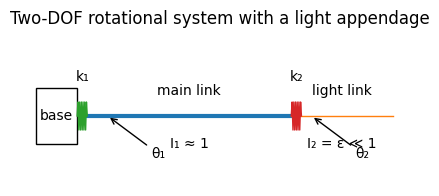

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(5, 2))

# Base block
ax.add_patch(plt.Rectangle((-0.5, -0.2), 0.4, 0.4, fill=False))
ax.text(-0.3, 0.0, "base", ha='center', va='center')

# First link
ax.plot([0.0, 2.0], [0.0, 0.0], lw=3)
ax.text(1.0, 0.15, "main link", ha='center')

# Light link
ax.plot([2.0, 3.0], [0.0, 0.0], lw=1)
ax.text(2.5, 0.15, "light link", ha='center')

# Springs as zigzags
def spring(x0, x1, y, n=6, amp=0.1):
    xs = np.linspace(x0, x1, 2*n+1)
    ys = y + amp * ((np.arange(2*n+1) % 2) * 2 - 1)
    ys[0] = y
    ys[-1] = y
    ax.plot(xs, ys, lw=1)

spring(-0.1, 0.0, 0.0)   # k1 at base
spring(2.0, 2.1, 0.0)    # k2 between links

ax.text(-0.05, 0.25, "k₁", ha='center')
ax.text(2.05, 0.25, "k₂", ha='center')

# Mark θ1, θ2
ax.annotate("θ₁", xy=(0.2, 0.0), xytext=(0.7, -0.3),
            arrowprops=dict(arrowstyle="->"), ha='center')
ax.annotate("θ₂", xy=(2.2, 0.0), xytext=(2.7, -0.3),
            arrowprops=dict(arrowstyle="->"), ha='center')

# Inertias
ax.text(1.0, -0.15, "I₁ ≈ 1", ha='center', va='top')
ax.text(2.5, -0.15, "I₂ = ε ≪ 1", ha='center', va='top')

ax.set_axis_off()
ax.set_xlim(-0.6, 3.2)
ax.set_ylim(-0.5, 0.6)
plt.title("Two-DOF rotational system with a light appendage")
plt.show()


In [8]:
k1 = 100.0
k2 = 10.0

K = np.array([
    [k1 + k2, -k2],
    [-k2,     k2]
])

def M_eps(eps):
    return np.array([
        [1.0 + eps, eps],
        [eps,       eps]
    ])

eps_values = 10.0**(-np.arange(0, 9))   # 1, 1e-1, ..., 1e-8
lam_vals = []
vecs = []

for eps in eps_values:
    M = M_eps(eps)
    lam, v = la.eig(K, M)
    # Sort
    idx = np.argsort(np.real(lam))
    lam_vals.append(np.real(lam[idx]))
    vecs.append(v[:, idx])

lam_vals = np.array(lam_vals)

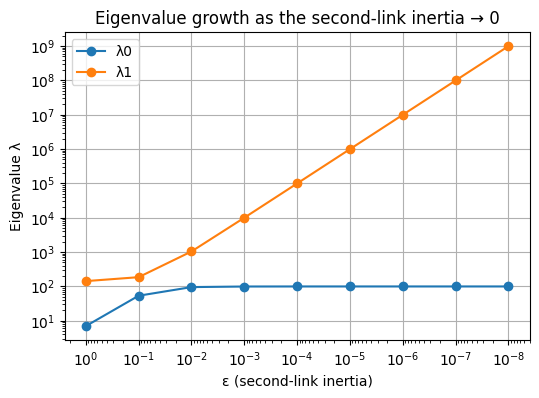

In [9]:
plt.figure(figsize=(6,4))
for j in range(2):
    plt.loglog(eps_values, lam_vals[:, j], marker='o', label=f'λ{j}')
plt.gca().invert_xaxis()
plt.xlabel("ε (second-link inertia)")
plt.ylabel("Eigenvalue λ")
plt.title("Eigenvalue growth as the second-link inertia → 0")
plt.grid(True)
plt.legend()
plt.show()


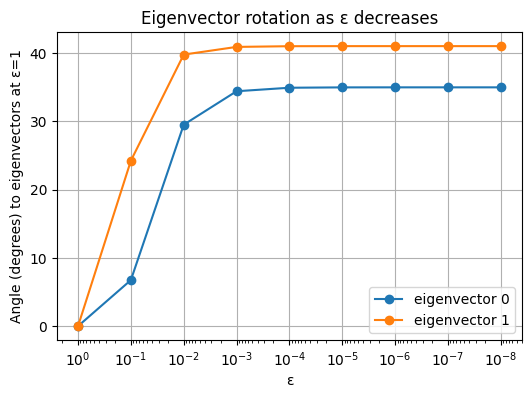

In [10]:
def angle(u, v):
    u = u/np.linalg.norm(u)
    v = v/np.linalg.norm(v)
    c = np.clip(np.abs(np.dot(u, v)), 0, 1)
    return np.degrees(np.arccos(c))

ref_vecs = vecs[0]   # eigenvectors at eps = 1

angles = []

for v in vecs:
    a0 = angle(v[:,0], ref_vecs[:,0])
    a1 = angle(v[:,1], ref_vecs[:,1])
    angles.append([a0, a1])

angles = np.array(angles)

plt.figure(figsize=(6,4))
for j in range(2):
    plt.semilogx(eps_values, angles[:,j], marker='o', label=f'eigenvector {j}')
plt.gca().invert_xaxis()
plt.xlabel("ε")
plt.ylabel("Angle (degrees) to eigenvectors at ε=1")
plt.title("Eigenvector rotation as ε decreases")
plt.grid(True)
plt.legend()
plt.show()


**Interpretation**

- As the sub-link inertia \( \varepsilon \) becomes very small,  
  the second generalized eigenvalue grows like \( 1/\varepsilon \).  
- Physically: the ultra-light appendage produces a very fast vibration mode.
- Numerically:  
  - The GEP becomes extremely ill-conditioned.  
  - Small perturbations in \( M(\varepsilon) \) or \(K\) cause large changes in eigenvectors.  
  - The "almost free" mode corresponds to the near-singularity of the inertia matrix.  

This example demonstrates a **real engineering source of GEP conditioning problems**,  
distinct from purely algebraic or artificial cases.


# 5.  Summary and Bridge to GSVD

<div style="float:left; padding-left:1.0cm;">

| Concept | Equation | Key Idea |
|:--|:--|:--|
| Standard EP | $A x = \lambda x$ | Unweighted modes |
| Generalized EP $\quad$ | $A x = \lambda B x \quad$ | Two metrics, $B$-orthogonality |
| GSVD | $A=U Σ_A X^T, B=V Σ_B X^T \qquad$ | Joint basis for paired subspaces |
</div>

- **Unifying view:** from RLC circuits to correlated datasets, the same algebraic structure governs modal relationships.
- **Numerical perspective:** well-conditioned B ensures stable eigenpairs.
- **Looking ahead:** the **GSVD** extends these ideas to non-square and rank-deficient pairs.